In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

2023-11-27 08:41:00.438945: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 08:41:00.440724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 08:41:00.465903: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 08:41:00.465930: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 08:41:00.465947: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# !wget https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5


In [79]:
!python -V, tf.__version__

Unknown option: -,
usage: python [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.


In [4]:
model = keras.models.load_model('bees-wasps.h5')

In [5]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input

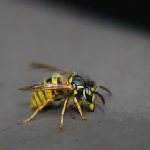

In [6]:
img = load_img('./wasp/906408394_d1a0a75e6d_n.jpg', target_size=(150,150))
img

In [7]:
x = np.array(img)
X = np.array([x])

X = preprocess_input(X)

In [8]:
X.shape

(1, 150, 150, 3)

In [9]:
pred = model.predict(X)

1/1 [==============================] - 0s 69ms/step


In [10]:
pred # probabilità che sia una wasp

array([[0.99915034]], dtype=float32)

In [11]:
wasp_probability = ['Wasp_probability']

In [12]:
dict(zip(wasp_probability, pred[0]))

{'Wasp_probability': 0.99915034}

In [13]:
#################################################################################
###
### This is what we usually do using keras and tensorflow packages.
### Let's convert it from Keras to tensorflow-Lite
###
#################################################################################

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) # creo l'oggetto converter passandogli il modello.h5

In [15]:
tflite_model = converter.convert() # salvo il modello lite che useremo

with open ('bees-wasps.tflite','wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_fju7id_/assets


INFO:tensorflow:Assets written to: /tmp/tmp_fju7id_/assets
2023-11-27 08:41:03.191616: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-27 08:41:03.191633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-27 08:41:03.192037: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_fju7id_
2023-11-27 08:41:03.192704: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-27 08:41:03.192713: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_fju7id_
2023-11-27 08:41:03.193927: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-27 08:41:03.194366: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-27 08:41:03.257820: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [16]:
!ls -lh # Answer question 1 : 43Mb !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1

totale 129M
drwxrwxr-x 2 francesco francesco 112K nov  4 21:12 bee
-rw-rw-r-- 1 francesco francesco  86M nov 17 22:51 bees-wasps.h5
-rw-rw-r-- 1 francesco francesco  43M nov 27 08:41 bees-wasps.tflite
-rw-rw-r-- 1 francesco francesco  13K nov 27 08:41 hw_9.ipynb
drwxrwxr-x 2 francesco francesco 104K nov  4 21:13 wasp


In [17]:
import tensorflow.lite as tflite 

In [18]:
# diversamente da prima lo si usa così :

In [19]:
interpreter = tflite.Interpreter(model_path='bees-wasps.tflite')
# load the model
interpreter.allocate_tensors()  
# load the weight, it is something that keras do automatically but with tflite need to be done explicitally

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
# look inside the input

interpreter.get_input_details() # -1 in shape sign : significa un numero infinito di immagini in input

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([  1, 150, 150,   3], dtype=int32),
  'shape_signature': array([ -1, 150, 150,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [21]:
# look inside the output

interpreter.get_output_details() # 1 in shape sign : significa che è una classificazione binaria :(Wasp_prob)

[{'name': 'StatefulPartitionedCall:0',
  'index': 13,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [22]:
# molte cose non avvengono in automatico qui, ma nel modello sono specificate le caratteristiche di in e out
# dobbiamo manualmente attrezzarci per capire come utilizzare il modello
# vediamo cosa ci serve : index per input ed index per output per iniziare :

In [23]:
input_index = interpreter.get_input_details()[0]['index']  # get INPUT index 
output_index = interpreter.get_output_details()[0]['index'] # get OUTPUT index 

input_index, output_index

(0, 13)

In [24]:
# Question 2 homework               13         !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [25]:
interpreter.set_tensor(input_index, X) # initialize input 

In [26]:
interpreter.invoke()  # pass trough all the NN layers

In [27]:
preds = interpreter.get_tensor(output_index) # fetch the output
preds

array([[0.9991503]], dtype=float32)

In [28]:
# vediamo che le predizioni sono le stesse di prima
# ma abbiamo usato tensorflowlite e no keras!

# ora abbiamo fatto le predizioni con tesorflowlite ma abbiamo ancora il preprocessing dell'immagine da fare :

In [29]:
!pip install pillow


In [30]:
# Code for downloading and resizing the image :

from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

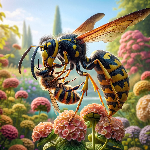

In [68]:
img = download_image('https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg')
img = prepare_image(img,(150,150))
img

In [69]:
x = np.array(img, dtype='float32')
x.shape

(150, 150, 3)

In [70]:
x

array([[[241., 231., 219.],
        [239., 235., 249.],
        [233., 229., 244.],
        ...,
        [ 74.,  85.,  42.],
        [ 89., 104.,  39.],
        [ 76.,  92.,  30.]],

       [[242., 232., 222.],
        [234., 232., 245.],
        [230., 228., 242.],
        ...,
        [ 70.,  86.,  41.],
        [120., 129.,  48.],
        [115., 126.,  47.]],

       [[237., 225., 209.],
        [233., 232., 246.],
        [231., 228., 245.],
        ...,
        [ 82.,  96.,  45.],
        [129., 134.,  52.],
        [110., 119.,  52.]],

       ...,

       [[  8.,  17.,  12.],
        [  6.,  22.,  12.],
        [ 21.,  21.,  23.],
        ...,
        [113.,  92.,  13.],
        [ 43.,  45.,  31.],
        [ 32.,  40.,  29.]],

       [[  8.,  17.,  12.],
        [ 20.,  30.,  22.],
        [ 14.,  25.,  19.],
        ...,
        [ 82.,  68.,  19.],
        [ 31.,  34.,  27.],
        [ 24.,  29.,  23.]],

       [[  5.,  10.,   6.],
        [ 22.,  29.,  21.],
        [ 26.,  

In [71]:
def preprocess_input(x):
    return x / 255


In [72]:
X = np.array([x])
X = preprocess_input(X)
X

array([[[[0.94509804, 0.90588236, 0.85882354],
         [0.9372549 , 0.92156863, 0.9764706 ],
         [0.9137255 , 0.8980392 , 0.95686275],
         ...,
         [0.2901961 , 0.33333334, 0.16470589],
         [0.34901962, 0.40784314, 0.15294118],
         [0.29803923, 0.36078432, 0.11764706]],

        [[0.9490196 , 0.9098039 , 0.87058824],
         [0.91764706, 0.9098039 , 0.9607843 ],
         [0.9019608 , 0.89411765, 0.9490196 ],
         ...,
         [0.27450982, 0.3372549 , 0.16078432],
         [0.47058824, 0.5058824 , 0.1882353 ],
         [0.4509804 , 0.49411765, 0.18431373]],

        [[0.92941177, 0.88235295, 0.81960785],
         [0.9137255 , 0.9098039 , 0.9647059 ],
         [0.90588236, 0.89411765, 0.9607843 ],
         ...,
         [0.32156864, 0.3764706 , 0.1764706 ],
         [0.5058824 , 0.5254902 , 0.20392157],
         [0.43137255, 0.46666667, 0.20392157]],

        ...,

        [[0.03137255, 0.06666667, 0.04705882],
         [0.02352941, 0.08627451, 0.04705882]

In [75]:
X[0,0,0,0] # Question 3 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!111

0.94509804

In [73]:
input_index = interpreter.get_input_details()[0]['index']  # get INPUT index 
output_index = interpreter.get_output_details()[0]['index'] # get OUTPUT index 

input_index, output_index

(0, 13)

In [74]:
# ora usiamo il codice di prima :
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index) 
preds

array([[0.65898407]], dtype=float32)

In [78]:
wasp_probability = ['Wasp_probability']
dict(zip(wasp_probability, preds[0]))

{'Wasp_probability': 0.65898407}